<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/39_4_Bert%3D%3D4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from transformers import pipeline
# model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
# model("Я тебя не")

In [1]:
%%capture
!pip install emoji==1.4.1
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
seed=42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.style.use("Solarize_Light2")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [3]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels = ['perfumes', 'smartphones', 'car-electronics', 'memory-cards',
       'wearables', 'tires', 'power-banks', 'portable-speakers',
       'car-audio', 'books', 'beauty', 'small-home-appl',
       'kitchen-home-appl']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

In [4]:
# Загружаем датасет
df = pd.read_csv("/content/sample_data/kaspi_reviews.csv", encoding='utf-8')
df.columns

Index(['Unnamed: 0', 'text', 'plus', 'minus', 'language', 'rating',
       'category'],
      dtype='object')

In [5]:
df

,Unnamed: 0,text,plus,minus,language,rating,category
0,0,"Парфюм оригинальный. Всё, как в профессиональн...",NaN,NaN,russian,5.0,perfumes
1,1,Мой любимый DKNY. Запах просто шикарный. Спаси...,NaN,NaN,russian,5.0,perfumes
2,2,NaN,Шикарный запах! Безумно нравится! Не пожалеете...,NaN,russian,5.0,perfumes
3,3,NaN,Иісі қатты ұнады.,NaN,kazakh,5.0,perfumes
4,4,"Запах просто классный, как раз то, что мне нуж...","Мне все понравилось - и качество товара, и зап...","Единственное, что мне не понравилось, это то, ...",russian,4.0,perfumes
...,...,...,...,...,...,...,...
119043,119043,NaN,"Звук выше среднего, немного токсичные высокие ...","Нет aptx, немного тяжеловаты.",russian,5.0,headphones
119044,119044,"Вполне сносные наушники, но, думаю, не стоит с...",NaN,NaN,russian,4.0,headphones
119045,119045,Наушники просто супер,NaN,NaN,russian,5.0,headphones
119046,119046,NaN,Всё супер,Басов маловато,russian,4.0,headphones


In [6]:
# Удаляем строки с казахским языком
df = df.drop(df[df['language'] == "kazakh"].index)

In [7]:
# Удаляем лишние столбцы
df = df.drop(['Unnamed: 0', 'plus', 'minus', 'language', 'rating'], axis=1)

In [8]:
# Удаляем все строки с пропущенными значениями
df = df.dropna()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55938 entries, 0 to 119045
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      55938 non-null  object
 1   category  55938 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [10]:
df['category'].unique()

array(['perfumes', 'smartphones', 'car-electronics', 'memory-cards',
       'wearables', 'tires', 'power-banks', 'portable-speakers',
       'car-audio', 'books', 'beauty', 'small-home-appl',
       'kitchen-home-appl', 'big-home-appl', 'climate-equipment',
       'watches', 'headphones'], dtype=object)

In [11]:
df['category'].value_counts()

,count
category,
smartphones,21497
kitchen-home-appl,5961
small-home-appl,5803
big-home-appl,5556
headphones,3076
beauty,3076
climate-equipment,2451
tires,1890
car-electronics,1833


In [12]:
df

,text,category
0,"Парфюм оригинальный. Всё, как в профессиональн...",perfumes
1,Мой любимый DKNY. Запах просто шикарный. Спаси...,perfumes
4,"Запах просто классный, как раз то, что мне нуж...",perfumes
5,"Парфюм хороший, оригинал! Магазин Parfum-Shop-...",perfumes
6,Доставка работает супер!,perfumes
...,...,...
119039,С большим телефоном без наушников себя не пред...,headphones
119040,"Купил наушники 3 недели назад, сначала очень п...",headphones
119042,Хорошие наушники,headphones
119044,"Вполне сносные наушники, но, думаю, не стоит с...",headphones


In [13]:
df_train = df[:50000]
df_test = df[50001:]

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 106766
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      50000 non-null  object
 1   category  50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5937 entries, 106768 to 119045
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      5937 non-null   object
 1   category  5937 non-null   object
dtypes: object(2)
memory usage: 139.1+ KB


In [16]:
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #удаляем emoji (смайлики)

# Удаляем пунктуацию, ссылки, упоминание других участников, символы конца строки и переноса \r\n
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # удаляем \n и \r и переводим строку в нижний регистр
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # удаление ссылок и упоминаний других участников
    text = re.sub(r'[^\x00-\x7f]',r'', text) # удаление символов не utf8/ascii, таких как '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' # символы для удаления, включая пунктуацию
    table = str.maketrans('', '', banned_list) # создание словаря замены
    text = text.translate(table) # применение к строке словаря замены
    return text

# убираем хэштеги в конце предложения и оставляем в середине, удалив только символ #
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) # удаление последнего хэштега
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) # удаление символа хэштега в середине предложения
    return new_tweet2

# Фильтрация специальных символов, таких как & и $, присутствующих в некоторых словах
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # удаление множественных пробелов с помощью регулярки
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df_train.text:
    texts_new.append(t)

In [ ]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(t)

In [18]:
# texts_new = []
# for t in df_train.text:
#     texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [19]:
# texts_new_test = []
# for t in df_test.text:
#     texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [20]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [21]:
df_train['text_clean'].head(3)

,text_clean
0,
1,dkny kaspikz parfumshopkz
4,


In [22]:
df_test['text_clean'].head(3)

,text_clean
106768,
106769,
106772,


In [23]:
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df_train['text_len'] = text_len

In [24]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

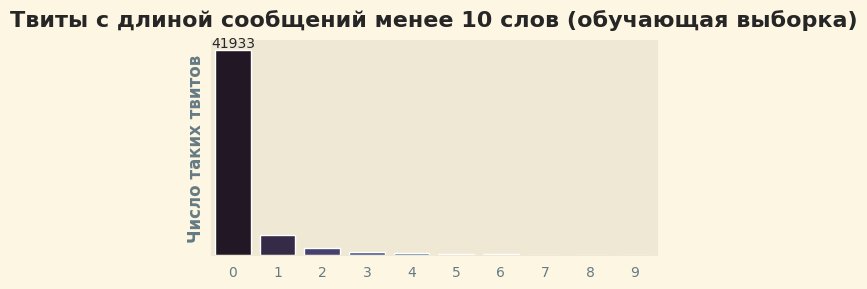

In [25]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (обучающая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

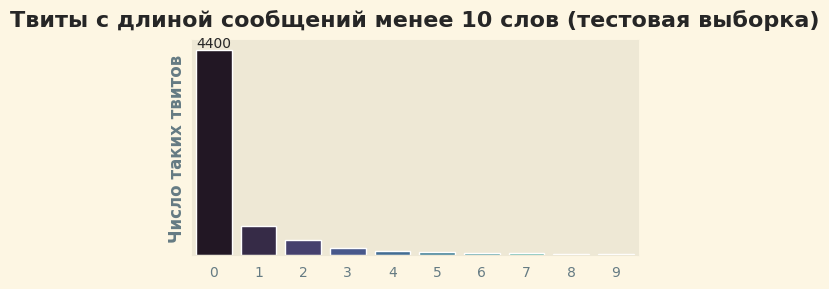

In [26]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (тестовая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()